<h1>Quora Insincere Questions Classification</h1>

<h2>Importing Data</h2>

In [10]:
import re
import pickle
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

X_train = train_df.drop(['qid','target'], axis =1 ).values
Y_train = train_df.target.values

<h2>Bahdanau Attention Model</h2>

In [2]:
class Attention(tf.keras.layers.Layer):
    '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self, att_units, name=None, **kwargs):
        super(Attention, self).__init__(name=name)
        #number of attention units to be provided
        self.att_units = att_units
        super(Attention, self).__init__(**kwargs)
        
        # Intialize variables needed for Concat score function here
        self.W1=tf.keras.layers.Dense(att_units)
        self.W2=tf.keras.layers.Dense(att_units)
        self.V=tf.keras.layers.Dense(1)

    def get_config(self):
        """
        get_config method is used here to avoid issues while importing saved moel with attention custom layer
        """
        config = super(Attention, self).get_config()
        config.update({"att_units": self.att_units})
        return config

    def call(self,lstm_output, hidden_state):
        
        """
        hidden state shape == (batch_size, hidden size)
        lstm output shape == (batch_size, max_length, hidden size)
        """
        
        #state_with_time_axis shape == (batch_size, 1, hidden size)
        #we are doing this to broadcast addition along the time axis to calculate the score
        state_with_time_axis = tf.expand_dims(hidden_state, 1)
        
        #score shape == (batch_size, max_length, 1)
        #we get 1 at the last axis because we are applying score to self.V
        #the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(state_with_time_axis) + self.W2(lstm_output)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights=tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights*lstm_output
        context_vector = tf.reduce_sum(context_vector, axis=1)  

        return context_vector, attention_weights

<h2>Function to Predict : : final_func_1 ( X )</h2>

<h3>Requirements:</h3>

<h5>1. <b>Pre-trained GloVe embedding file</b></h5>
<pre>PATH :: "/embeddings/glove_embedding.pkl"
CONTAINS :: Dictionary of words and their pre-trained embeddings</pre>

<h5>2. <b>Preprocessing Files</b></h5>
<pre>PATH :: "/PreprocessingFiles/symbols.pkl"
CONTAINS :: Dictionary of symbols and their word meanings</pre>

<pre>PATH :: "/PreprocessingFiles/remove_characters.pkl"
CONTAINS :: String of characters to be removed</pre>

<pre>PATH :: "/PreprocessingFiles/contractions.pkl"
CONTAINS :: List of english known contractions</pre>

<pre>PATH :: "/PreprocessingFiles/characters_list.pkl"
CONTAINS :: List of characters of english language to keep in the text files</pre>

<pre>PATH :: "/PreprocessingFiles/replace_words.pkl"
CONTAINS :: Dictionary of mispelled and unknown worda of english language and their correct spelling & interpretations</pre>

<h5>3. <b>Sequence Padding</b></h5>
<pre>PATH :: "/PreprocessingFiles/tokenizers.pkl"
CONTAINS :: keras tokenizer file</pre>


<h2>Final Function</h2>

In [ ]:
"""Importing the GloVe Embedding file for preprocessing"""
embedding = pickle.load(open("/embeddings/glove_embedding.pkl", 'rb'))

In [25]:
def final_func_1(input):
    
    """
    1. Preprocessing Files

    PATH :: "/PreprocessingFiles/symbols.pkl"
    CONTAINS :: Dictionary of symbols and their word meanings

    PATH :: "/PreprocessingFiles/remove_characters.pkl"
    CONTAINS :: String of characters to be removed

    PATH :: "/PreprocessingFiles/contractions.pkl"
    CONTAINS :: List of english known contractions

    PATH :: "/PreprocessingFiles/characters_list.pkl"
    CONTAINS :: List of characters of english language to keep in the text files
    
    PATH :: "/PreprocessingFiles/replace_words.pkl"
    CONTAINS :: Dictionary of mispelled and unknown worda of english language and their correct spelling & interpretations
    
    2. Sequence Padding

    PATH :: "/PreprocessingFiles/tokenizers.pkl"
    CONTAINS :: keras tokenizer file
    """

    """
    uploading pickle files
    """
    start = time()
    replace_symbols = pickle.load(open("/PreprocessingFiles/symbols.pkl", 'rb'))
    remove_chars = pickle.load(open("/PreprocessingFiles/remove_characters.pkl", 'rb'))
    contraction = pickle.load(open("/PreprocessingFiles/contractions.pkl", 'rb'))
    characters_list = pickle.load(open("/PreprocessingFiles/characters_to_keep.pkl", 'rb'))
    replace_word = pickle.load(open("/PreprocessingFiles/replace_words.pkl", 'rb'))
    tokenizer = pickle.load(open("/PreprocessingFiles/tokenizers.pkl", 'rb'))

    """
    preprocessing the data
    """
    preprocessed_df = list() 
    for ele in input:
        sent = ele[0]
        #replacing symbols with their meanings
        for sym in replace_symbols:
            if sym in sent:
                sent = sent.replace(sym, replace_symbols[sym])
        #removing unwanted characters
        translate_table = dict((ord(char), None) for char in remove_chars)
        sent = sent.translate(translate_table)
        #remove generic contraction
        sent = ' '.join(word.replace(word,contraction[word]) if word in contraction else word for word in sent.split())
        sent = re.sub(r"\"s", " ", sent); sent = re.sub(r"\'s", " ", sent); sent = re.sub(r"\''s", " ", sent)
        sent = re.sub(r"n\"t", " not ", sent); sent = re.sub(r"n\''t", " not ", sent); sent = re.sub(r"n\'t", " not ", sent)
        sent = re.sub(r"\'ll ", " will", sent); sent = re.sub(r"\''ll ", " will", sent); sent = re.sub(r"\"ll ", " will", sent)
        sent = re.sub(r"\'d ", " would", sent); sent = re.sub(r"\"d ", " would", sent); sent = re.sub(r"\''d ", " would", sent)
        sent = re.sub(r"\'ve ", " have", sent); sent = re.sub(r"\''ve ", " have", sent); sent = re.sub(r"\"ve ", " have", sent)
        sent = re.sub(r"\'re ", " are ", sent); sent = re.sub(r"\'m ", " am", sent); sent = re.sub(r"\''m "," am", sent)
        sent = re.sub(r"\"m "," am", sent); sent = re.sub("\s{2}"," ",sent)
        sent = sent.strip()
        #spacing of existing character
        for char in characters_list:
            if char in sent:
                sent = sent.replace(char," "+char+" ")
                sent = re.sub("\s+"," ",sent)
        #checking word format
        wordList = sent.split()
        for word in wordList:
            if word not in embedding:
                if word.lower() in embedding:
                    sent = sent.replace(word, word.lower())
                elif word.title() in embedding:
                    sent = sent.replace(word, word.title())
                elif word.upper() in embedding:
                    sent = sent.replace(word, word.upper())
            else:
                pass
        #replace values
        sent = ' '.join(word.replace(word,replace_word[word]) if word in replace_word else word for word in sent.split())
        #appending preprocessed sentences to a list
        preprocessed_df.append(sent)

    """
        padding of data
    """
    #tonization and sequence padding of data
    Xdata = tokenizer.texts_to_sequences(preprocessed_df)
    Xdata = pad_sequences(Xdata, maxlen = 75, padding='post')
  
    print('Time for Preprocessing and Featursiation is :: {}  sec' .format(time() - start))

    """
        predicting data
    """
    now = time()
    output = list()
    model = load_model("/AttentionModel", custom_objects={'Attention': Attention})
    ypred = model.predict(Xdata, verbose=1)
    threshold = {0.1: 0.612, 0.15: 0.642, 0.2: 0.66, 0.25: 0.671, 0.3: 0.676, 0.35: 0.678, 0.4: 0.679, 0.45: 0.673, 0.5: 0.665}
    for i in ypred:
        output.append((i[1]>max(threshold, key=threshold.get)).astype(int))

    print('Time for inference is :: {}  sec' .format(time() - now))

    return output

<h2>Single Data as Input and corresponding output</h2>

<pre>
output has 2 values. 
0 - Sincere Question
1 - Insincere Question
</pre>

In [11]:
#giving input file
input = X_train[500:501]
print(input)

[['What are the reasons for drug trafficking?']]


In [12]:
#getting output
output = final_func_1(input)

Time for Preprocessing and padding is :: 0.254824161529541  sec
1/1 [==============================] - 0s 2ms/step
Time for inference is :: 2.851763963699341  sec


In [13]:
print(output)

[0]


<h2>Batch Input and Output</h2>

In [8]:
#giving input file
input = X_train[1000:1030]
#getting output
output = final_func_1(input)

Time for Preprocessing and padding is :: 0.2724735736846924  sec
1/1 [==============================] - 0s 1ms/step
Time for inference is :: 2.591470718383789  sec


In [9]:
print(output)

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


<h2>Function to Calculate f1_score : : final_func_2 (X, Y)</h2>

In [ ]:
def final_func_2(X, Y):
    """
    Input :: X (Text Features), Y (Target Values)
    Output :: f1_score
    """
    return f1_score(Y,final_func_1(X)

<h2>Test Data </2>

In [17]:
#getting input
input = test_df.drop(['qid'], axis =1).values
#getting output
ypred = final_func_1(input)

Time for Preprocessing and padding is :: 57.08582925796509  sec
11744/11744 [==============================] - 419s 36ms/step
Time for inference is :: 423.80863070487976  sec


In [20]:
#submitting final data
y_final = pd.read_csv("sample_submission.csv").drop('prediction',axis=1)
y_final['prediction'] = ypred
y_final.to_csv('submission.csv', index=False)

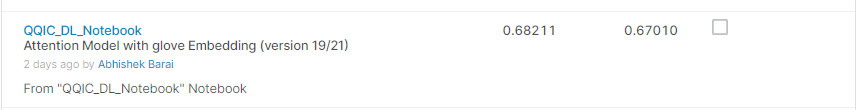

In [36]:
from IPython.display import Image
Image(filename = "/content/drive/My Drive/Quora_Insincere_Questions_Classification/final_score.jpg" ,width = 1500 , height = 200)